In [1]:
import os

import himalaya
import numpy as np
from more_itertools import first
from scipy.stats import zscore
from voxelwise_tutorials.io import load_hdf5_array
from voxelwise_tutorials.viz import plot_flatmap_from_mapper
from himalaya.backend import set_backend
from fmri.features import load_feature
from voxelwise_tutorials.utils import explainable_variance

In [27]:
def blockwise_permutation_test(predicted, actual, tr_block_size=10, n_permutations=10000):
    """
    Performs a voxel-wise permutation test with blockwise shuffling.

    Parameters:
        predicted (numpy array): Predicted voxel responses, shape (timepoints, voxels).
        actual (numpy array): Actual voxel responses, shape (timepoints, voxels).
        n_voxels (int): Number of voxels (columns in predicted/actual).
        tr_block_size (int): Size of blocks for shuffling (default 10 TRs).
        n_permutations (int): Number of permutations (default 10,000).

    Returns:
        observed_correlations (numpy array): Observed correlation per voxel.
        p_values (numpy array): p-value per voxel (uncorrected).
        fdr_corrected_p_values (numpy array): FDR-corrected p-values.
    """
    n_timepoints = actual.shape[0]  # Number of time points
    n_voxels = actual.shape[1]  # Number of voxels

    # Compute observed correlations per voxel
    observed_correlations = [np.corrcoef(predicted[:, v], actual[:, v])[0, 1] for v in range(n_voxels)]

    # Create null distributions for each voxel
    null_distributions = np.zeros((n_permutations, n_voxels))

    for i in range(n_permutations):
        if i % 100 == 0:
            print(f"\rPermutation {i}/{n_permutations}")
        permuted_actual = actual.copy()

        # Blockwise shuffle
        indices = np.arange(n_timepoints)
        block_indices = [indices[j:j + tr_block_size] for j in range(0, len(indices), tr_block_size)]
        np.random.shuffle(block_indices)
        shuffled_indices = np.concatenate(block_indices)

        permuted_actual = permuted_actual[shuffled_indices, :]  # Apply shuffled indices

        # Compute correlations for each voxel
        for v in range(n_voxels):
            null_distributions[i, v] = np.corrcoef(predicted[:, v], permuted_actual[:, v])[0, 1]

    # Compute p-values for each voxel
    p_values = np.mean(np.abs(null_distributions) >= np.abs(observed_correlations), axis=0)

    # Apply FDR correction
    _, fdr_corrected_p_values = fdrcorrection(p_values, alpha=0.05, method='indep')

    return p_values, fdr_corrected_p_values

In [29]:
from joblib import Parallel, delayed


def blockwise_permutation_test(predicted, actual, tr_block_size=10, n_permutations=10000, n_jobs=-1):
    """
    Performs a voxel-wise permutation test with blockwise shuffling.

    Parameters:
        predicted (numpy array): Predicted voxel responses, shape (timepoints, voxels).
        actual (numpy array): Actual voxel responses, shape (timepoints, voxels).
        tr_block_size (int): Size of blocks for shuffling (default 10 TRs).
        n_permutations (int): Number of permutations (default 10,000).
        n_jobs (int): Number of jobs to run in parallel (default -1, which means using all processors).

    Returns:
        observed_correlations (numpy array): Observed correlation per voxel.
        p_values (numpy array): p-value per voxel (uncorrected).
        fdr_corrected_p_values (numpy array): FDR-corrected p-values.
    """
    n_timepoints = actual.shape[0]  # Number of time points
    n_voxels = actual.shape[1]  # Number of voxels

    # Compute observed correlations per voxel
    observed_correlations = [np.corrcoef(predicted[:, v], actual[:, v])[0, 1] for v in range(n_voxels)]

    # Function to perform a single permutation
    def single_permutation(i):
        if i % 100 == 0:
            print(f"\rPermutation {i}/{n_permutations}")
        permuted_actual = actual.copy()

        # Blockwise shuffle
        indices = np.arange(n_timepoints)
        block_indices = [indices[j:j + tr_block_size] for j in range(0, len(indices), tr_block_size)]
        np.random.shuffle(block_indices)
        shuffled_indices = np.concatenate(block_indices)

        permuted_actual = permuted_actual[shuffled_indices, :]  # Apply shuffled indices

        # Compute correlations for each voxel
        return [np.corrcoef(predicted[:, v], permuted_actual[:, v])[0, 1] for v in range(n_voxels)]

    # Create null distributions for each voxel using parallel processing
    null_distributions = np.array(Parallel(n_jobs=n_jobs)(delayed(single_permutation)(i) for i in range(n_permutations)))

    # Compute p-values for each voxel
    p_values = np.mean(np.abs(null_distributions) >= np.abs(observed_correlations), axis=0)

    # Apply FDR correction
    _, fdr_corrected_p_values = fdrcorrection(p_values, alpha=0.05, method='indep')

    return p_values, fdr_corrected_p_values

In [44]:
import cupy as cp
from statsmodels.stats.multitest import fdrcorrection

print(cp.cuda.runtime.getDeviceCount())

def blockwise_permutation_test(predicted, actual, tr_block_size=10, n_permutations=10000):
    """
    Performs a voxel-wise permutation test with blockwise shuffling.

    Parameters:
        predicted (cupy.ndarray): Predicted voxel responses, shape (timepoints, voxels).
        actual (cupy.ndarray): Actual voxel responses, shape (timepoints, voxels).
        tr_block_size (int): Size of blocks for shuffling (default 10 TRs).
        n_permutations (int): Number of permutations (default 10,000).

    Returns:
        observed_correlations (cupy.ndarray): Observed correlation per voxel.
        p_values (cupy.ndarray): p-value per voxel (uncorrected).
        fdr_corrected_p_values (cupy.ndarray): FDR-corrected p-values.
    """
    n_timepoints = actual.shape[0]  # Number of time points
    n_voxels = actual.shape[1]  # Number of voxels

    # convert to cupy arrays
    predicted = cp.array(predicted)
    actual = cp.array(actual)

    # Create null distributions for each voxel
    null_distributions = cp.zeros((n_permutations, n_voxels))

    for i in range(n_permutations):
        if i % 100 == 0:
            print(f"\rPermutation {i}/{n_permutations}")
        permuted_actual = actual.copy()

        # Blockwise shuffle
        indices = cp.arange(n_timepoints)
        block_indices = [indices[j:j + tr_block_size] for j in range(0, len(indices), tr_block_size)]

        # TypeError: The array must be cupy.ndarray
        cp.random.shuffle(block_indices)


        shuffled_indices = cp.concatenate(block_indices)

        permuted_actual = permuted_actual[shuffled_indices, :]  # Apply shuffled indices

        # Compute correlations for each voxel
        for v in range(n_voxels):
            null_distributions[i, v] = cp.corrcoef(predicted[:, v], permuted_actual[:, v])[0, 1]

    # Compute observed correlations per voxel
    observed_correlations = cp.array([cp.corrcoef(predicted[:, v], actual[:, v])[0, 1] for v in range(n_voxels)])

    # Compute p-values for each voxel
    p_values = cp.mean(cp.abs(null_distributions) >= cp.abs(observed_correlations), axis=0)

    # Apply FDR correction
    p_values_np = cp.asnumpy(p_values)
    _, fdr_corrected_p_values = fdrcorrection(p_values_np, alpha=0.05, method='indep')

    # convert to numpy arrays
    observed_correlations = cp.asnumpy(observed_correlations)
    p_values = cp.asnumpy(p_values)

    return observed_correlations, p_values, fdr_corrected_p_values

1


In [2]:
backend = set_backend('torch_cuda', on_error='warn')

In [10]:
X, _ = load_feature("../../data", "letters")

/home/leo/PycharmProjects/compare_variance_residual/compare_variance_residual/fmri/features.py:23: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  story_data = zscore(story_data)
/home/leo/PycharmProjects/compare_variance_residual/compare_variance_residual/fmri/features.py:23: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  story_data = zscore(story_data)
/home/leo/PycharmProjects/compare_variance_residual/compare_variance_residual/fmri/features.py:23: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  story_data = zscore(story_data)
/home/leo/PycharmProjects/compare_variance_residual/compare_variance_residual/fmri/featu

In [48]:
subject = 9
modality = "reading"

Y_train_filename = os.path.join("../../data", 'responses', f'subject{subject:02}_{modality}_fmri_data_trn.hdf')
Y_test_filename = os.path.join("../../data", 'responses', f'subject{subject:02}_{modality}_fmri_data_val.hdf')
Y_train_hdf = load_hdf5_array(Y_train_filename)
Y_test_hdf = load_hdf5_array(Y_test_filename)

trim = 5

run_onsets = [0]

Y_train = None
for story in Y_train_hdf.keys():
    print(story)
    story_data = Y_train_hdf[story][:-trim]
    story_data = story_data.astype(np.float32)
    story_data = np.nan_to_num(story_data)
    story_data = zscore(story_data)

    if Y_train is None:
        Y_train = story_data
    else:
        Y_train = np.concatenate([Y_train, story_data])

    run_onsets.append(run_onsets[-1] + story_data.shape[0])
# remove last element
run_onsets = run_onsets[:-1]

n_samples_train = Y_train.shape[0]

Y_test = []
eval_story = first(Y_test_hdf.keys())
for i in range(2):
    story_data = Y_test_hdf[eval_story][i][:-trim]
    story_data = story_data.astype(np.float32)
    story_data = np.nan_to_num(story_data)
    story_data = zscore(story_data)
    Y_test.append(story_data)
Y_test = np.nan_to_num(Y_test)

# calculate explainable variance
ev = explainable_variance(Y_test)

Y = np.vstack([Y_train, np.mean(Y_test, axis=0)])
Y = np.nan_to_num(Y)
ev

story_01
story_02


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 363 and the array at index 1 has size 387

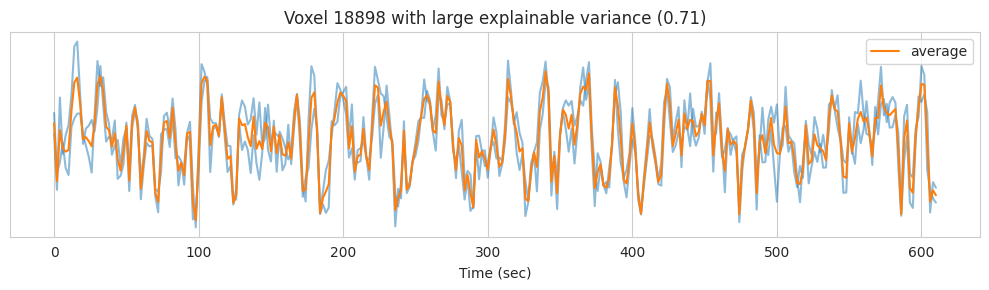

In [43]:
import matplotlib.pyplot as plt

voxel_1 = np.nanargmax(ev)
time = np.arange(Y_test.shape[1]) * 2  # one time point every 2 seconds
plt.figure(figsize=(10, 3))
plt.plot(time, Y_test[:, :, voxel_1].T, color='C0', alpha=0.5)
plt.plot(time, Y_test[:, :, voxel_1].mean(0), color='C1', label='average')
plt.xlabel("Time (sec)")
plt.title(f"Voxel {voxel_1} with large explainable variance ({ev[voxel_1]:.2f})")
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()

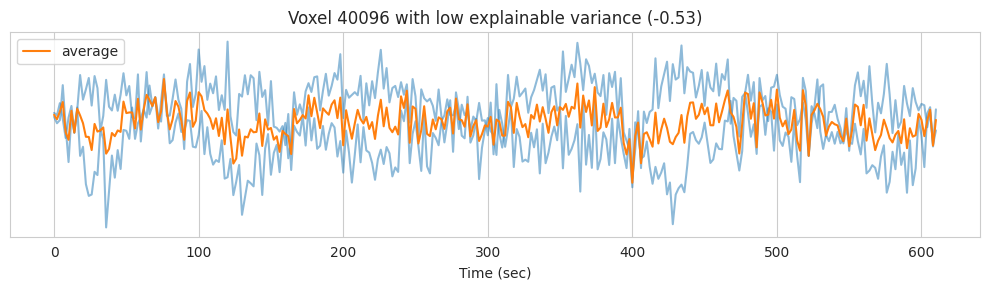

In [44]:
voxel_2 = np.nanargmin(ev)
plt.figure(figsize=(10, 3))
plt.plot(time, Y_test[:, :, voxel_2].T, color='C0', alpha=0.5)
plt.plot(time, Y_test[:, :, voxel_2].mean(0), color='C1', label='average')
plt.xlabel("Time (sec)")
plt.title(f"Voxel {voxel_2} with low explainable variance ({ev[voxel_2]:.2f})")
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()

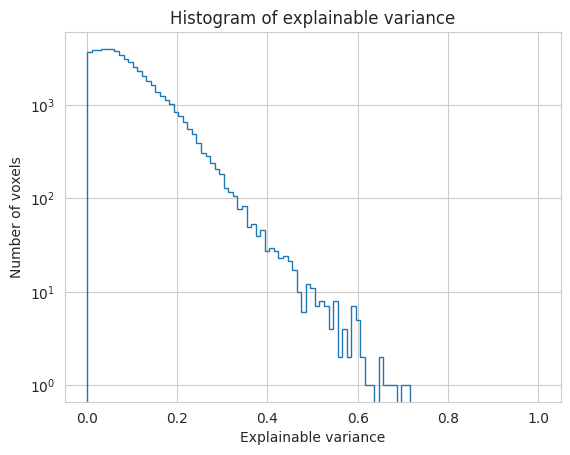

In [45]:
plt.hist(ev, bins=np.linspace(0, 1, 100), log=True, histtype='step')
plt.xlabel("Explainable variance")
plt.ylabel("Number of voxels")
plt.title('Histogram of explainable variance')
plt.grid('on')
plt.show()

In [11]:
from sklearn.pipeline import make_pipeline
from himalaya.ridge import RidgeCV
from voxelwise_tutorials.utils import generate_leave_one_run_out, explainable_variance
from voxelwise_tutorials.delayer import Delayer

delayer = Delayer(delays=range(1, 5))
solver_params = dict(n_targets_batch=100, n_alphas_batch=5, n_targets_batch_refit=5, score_func=himalaya.scoring.r2_score)
cv = generate_leave_one_run_out(n_samples_train, run_onsets)
ridge_cv = RidgeCV(alphas=np.logspace(-5, 20, 26), cv=cv, solver_params=solver_params)
pipeline = make_pipeline(delayer, ridge_cv)

pipeline.fit(X[:n_samples_train], Y[:n_samples_train])
prediction = pipeline.predict(X[n_samples_train:])
prediction = backend.to_numpy(prediction)

/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [45]:
p_value, fdr_corrected_p_value = blockwise_permutation_test(prediction, Y[n_samples_train:], n_permutations=1000)
p_value

Permutation 0/1000


TypeError: Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.

In [ ]:
mapper_file = "../../data/mapper/subject01_mappers.hdf"

In [ ]:
plot_flatmap_from_mapper(p_value, mapper_file, cmap='magma')